# CHALLENGE: Predicting diabete 
## (EXAMPLE OF A VERY GOOD SOLUTION PROVIDED BY A STUDENT)
In this challenge, you have to use a linear LM model to predict a target value that is a measure of disease (diabete) progression using 10 measurements. The [diabete dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html) is a standard dataset for linear regression and is available on the [sklearn](https://scikit-learn.org/) library.

The following steps show how to import and set this dataset.

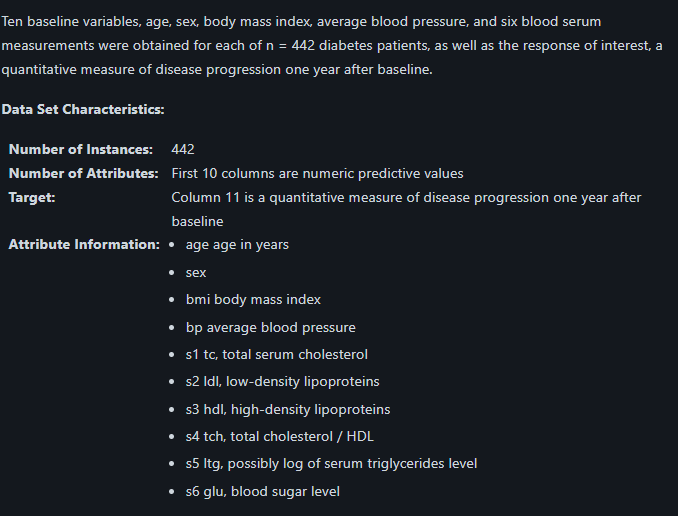

Info on the dataset: we have 442 data entries, each of them is a vector of $\mathbb R^{10}$.  

Each entry is of the form $(x_i, y_i)$ where $x_i \in \mathbb R^{10}$, $y_i \in \mathbb R$.

In [ ]:
from sklearn.datasets import load_diabetes
import numpy as np

rawdata = load_diabetes()  # it's a dictionary

print([k for k in rawdata])

In [ ]:
# First 5 target values   (they are the y_i)
rawdata.target[:10]

In [ ]:
# First 5 input vectors   (x_i)
print(rawdata.data[:3])    # it has been preprocessed

In [ ]:
# To set your data set
Xs = rawdata.data
Ys = rawdata.target

# To split the train and test set  (usually 20% is the test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xs, Ys, test_size=0.2, random_state=13)


In [ ]:
X_train[1]

In [ ]:
print(np.array([X_train[1]**i for i in range(11)]).shape)

**ASSIGNMENT:** You have to implement the following function with the best ILP model to fit a linear regression model using Gurobi. The fit function must return a **predict** function, similarly to the function used to fit a polynomial.
### PROPOSED SOLUTION

In [ ]:
import numpy as np
import math
from itertools import product

At first, the model we decided to work on was of the form:

$$F_W\begin{pmatrix} x_1 \\ \vdots \\ x_N \end{pmatrix} = 
\begin{pmatrix} w_{10} \\ w_{11} \\ w_{12} \\ \vdots \\ w_ {1q} \end{pmatrix} \cdot \begin{pmatrix} 1 \\ x_1\\ x_1^2 \\ \vdots \\ x_1^q \end{pmatrix} 
+
\begin{pmatrix} w_{20} \\ w_{21} \\ w_{22} \\ \vdots \\ w_ {2q} \end{pmatrix} \cdot \begin{pmatrix} 1 \\ x_2\\ x_2^2 \\ \vdots \\ x_2^q \end{pmatrix} 
+ ... + 
\begin{pmatrix} w_{N0} \\ w_{N1} \\ w_{N2} \\ \vdots \\ w_ {Nq} \end{pmatrix} \cdot \begin{pmatrix} 1 \\ x_N\\ x_N^2 \\ \vdots \\ x_N^q \end{pmatrix} , 
$$
where $\cdot$ indicates the dot product between two vectors. 


This model has $N \cdot (q+1)$ variables, and gives polynomials of degree q that are non mixed. **(type "poly_simple" in the code)**

Another type of model we decided to try was:
$$F_W\begin{pmatrix} x_1 \\ \vdots \\ x_N \end{pmatrix} = 
\begin{pmatrix} w_{10} \\ w_{11} \\ w_{12} \\ \vdots \\ w_ {1q} \end{pmatrix} \cdot \begin{pmatrix} \phi_1^0(x_1) \\ \phi_1^1(x_1)\\ \phi_1^2(x_1) \\ \vdots \\ \phi_1^q(x_1) \end{pmatrix} 
+
\begin{pmatrix} w_{20} \\ w_{21} \\ w_{22} \\ \vdots \\ w_ {2q} \end{pmatrix} \cdot \begin{pmatrix} \phi_2^0(x_2) \\ \phi_2^1(x_2)\\ \phi_2^2(x_2) \\ \vdots \\ \phi_2^q(x_2) \end{pmatrix} 
+ ... +
\begin{pmatrix} w_{N0} \\ w_{N1} \\ w_{N2} \\ \vdots \\ w_ {Nq} \end{pmatrix} \cdot \begin{pmatrix} \phi_N^0(x_N) \\ \phi_N^1(x_N)\\ \phi_N^2(x_N) \\ \vdots \\ \phi_N^q(x_N) \end{pmatrix} 
,$$

where $ \phi_j^i : \mathbb R \to \mathbb R$ are other non linear functions, with $i=0..q$, $j = 1..N$, chosen so they make a basis of the space of the continuous functions of a closed interval. With the help of Chatgpt and some additional research, the non linear functions used in this code are:

- the gaussian function **(type "gaussian" in the code)**: $$\phi_j^i(x_j) = e^{\frac{-(x_j- c_{i,j})^2}{2\sigma_j}}$$
- the sigmoid function:**(type "sigmoid" in the code)** $$ \phi_j^i(x_j) =  \frac{1}{1+e^{-(x_j- c_{i,j})}}$$
- the tanh function: **(type "tanh" in the code)** $$ \phi_j^i(x_j) = tanh(x_j- c_{i,j})$$

The parameters $c_{i,j}$ and $\sigma_j$ are chosen as follows: if $a_j = \min(x_j,x \in Xs)$, where $Xs$ is the test set, and $b_j = \max(x_j,x \in Xs)$, then:
- $c_{i,j} = a_j + \frac{i}{q}(b_j-a_j)$  (evenly spaces "centers" for the functions)
- $\sigma_j = \frac{b-a}{\sqrt{2q}}$

The last option we tried was using mixed polynomials of degree $q$ **(type "poly" in the code)**: those are of the form:
$$F_W\begin{pmatrix} x_1 \\ \vdots \\ x_N \end{pmatrix} = \sum_{|\alpha| \leq q} w_\alpha \, x^\alpha, $$
where each $\alpha$ is a multi index of order smaller than $q$.

The implementation of these models is as follows:

In [ ]:
from gurobipy import Model, GRB, quicksum, Env

def FittingMultiDim(Xs, Ys, q = 10, type = "poly_single", name = "multi_dimensional"):
    # LP model        
    env = Env(params={'OutputFlag': 0})
    model = Model(env=env)
    
    N = Xs.shape[1]
    K = Xs.shape[0]
    # Add variables

    a = np.array([min([Xs[k][j] for k in range(K)]) for j in range(N)])  # min of all components 
    b = np.array([max([Xs[k][j] for k in range(K)]) for j in range(N)])  # max of all components
    c = np.array([a+ (i/q)*(b-a) for i in range(q+1)])
    sigma  = (b-a)/np.sqrt(2*q)
    
    # structure of the variables
    if type=="poly": 
        # number of degrees of freedom: = (q+N)!/(q!N!)
        dof = int(math.factorial(N+q)/(math.factorial(N)*math.factorial(q)))
        W = model.addVars(dof, lb= -GRB.INFINITY, obj = 0 , name = "W")
        exponents = [exp for exp in product(range(q+1), repeat=N) if sum(exp) <= q]         # multi indices made with the help of chatgpt
    else: # a matrix
        W = model.addVars(N, q+1, lb= -GRB.INFINITY, obj = 0 , name = "W")

    def fw(x):
        if type == "poly":
            return np.array(W.select("*")).dot( np.array([np.prod(np.array([x[j]**e for j, e in enumerate(exp)])) for exp in exponents]))
        if type == "poly_single":  # polinomial of degree q, but only with terms x_i^k and not x_i^k * x_j^l
            return quicksum([W.select(j, '*') @ np.array([x[j]**i for i in range(q+1)]) for j in range(N)])
        if type == "gaussian":      # here we have q functions of the gaussian form
            return quicksum([W.select(j, '*') @ np.array([ np.exp(-(x[j]- c[i,j])**2 / (2*sigma[j])) for i in range(q+1)]) for j in range(N)])
        if type == "sigmoid":
            return quicksum([W.select(j, '*') @ np.array([ (1+np.exp(-(x[j]- c[i,j])))**(-1) for i in range(q+1)]) for j in range(N)])
        if type == "tanh":
            return quicksum([W.select(j, '*') @ np.array([ np.tanh(x[j]- c[i,j]) for i in range(q+1)]) for j in range(N)])
    
    model.update()

    # linearise absolute value
    z = model.addVars(K, lb = 0, obj = 1/K, name = "z")
    for i in range(K):
        model.addConstr(z[i] >= fw(Xs[i])-Ys[i])
        model.addConstr(z[i] >= -fw(Xs[i])+Ys[i])

    model.write(name + ".lp")
    model.update()
    model.optimize()

    if type == "poly":
        w_sol = np.array([W.select(k)[0].X for k in range(dof)])
    else:
        w_sol = np.array([[W.select(k,l)[0].X for l in range(q+1)] for k in range(N)])

    # same as the fw of before, checking when the input is a whole set and not only an entry x in R^10
    def F(x): 
        if x.shape==(N,):
            if type=="poly":
                return w_sol.dot( np.array([ np.prod(np.array([x[j]**e for j, e in enumerate(exp)])) for exp in exponents]) )
            if type == "poly_single":
                return sum([w_sol[j, :] @ np.array([x[j]**i for i in range(q+1)]) for j in range(N)])
            if type == "gaussian":
                return sum([w_sol[j, :] @ np.array([ np.exp(-(x[j]- c[i,j])**2 / (2*sigma[j])) for i in range(q+1)]) for j in range(N)])
            if type == "sigmoid":
                return sum([w_sol[j, :] @ np.array([ (1+np.exp(-(x[j]- c[i,j])))**(-1) for i in range(q+1)]) for j in range(N)])
            if type == "tanh":
                return sum([w_sol[j, :] @ np.array([ np.tanh(x[j]- c[i,j]) for i in range(q+1)]) for j in range(N)])
            
        else:
            K = x.shape[0]
            if type=="poly":
                return np.array([w_sol.dot(np.array([ np.prod(np.array([x[j]**e for j, e in enumerate(exp)])) for exp in exponents])) for l in range(K)])
            if type=="poly_single":
                return np.array([sum([w_sol[j, :] @ np.array([x[l][j]**i for i in range(q+1)]) for j in range(N)]) for l in range(K)])
            if type == "gaussian":
                return np.array([sum([w_sol[j, :] @ np.array([ np.exp(-(x[l][j]- c[i,j])**2 / (2*sigma[j])) for i in range(q+1)]) for j in range(N)]) for l in range(K)])
            if type == "sigmoid":
                return np.array([sum([w_sol[j, :] @ np.array([ (1+np.exp(-(x[l][j]- c[i,j])))**(-1) for i in range(q+1)]) for j in range(N)]) for l in range(K)])
            if type == "tanh":
                return np.array([sum([w_sol[j, :] @ np.array([ np.tanh(x[l][j]- c[i,j]) for i in range(q+1)]) for j in range(N)]) for l in range(K)])
    return F

Notice that the different versions of the model ("poly_single", "gaussian", "sigmoid" and "tanh") are very similar and require the same initialisation of the variables W. "poly" is different: the variables are in vector form.

We use the RMS error to check performance of the different models.

In [ ]:
def RMS(Xs, Ys, F):
    return np.sqrt(sum((F(x) - y)**2 for x, y in zip(Xs, Ys)) / len(Xs))

In [ ]:
for q in range(1, 4):
    print("q=", q)
    for s in ["poly", "poly_single", "gaussian", "sigmoid", "tanh"]:
        F = FittingMultiDim(X_train, y_train, q = q, type = s, name = "diabetes")
        print(s)
        print("RMS for training: {}".format(RMS(X_train, y_train, F)))
        print("RMS for testing: {}".format(RMS(X_test, y_test, F)))

We can plot the same results for the test set: (using q > 5 gives huge evaluation time for the "poly" model, and does not increase performance.)

In [ ]:
import matplotlib.pyplot as plt
RMS_poly = []
RMS_poly_single = []
RMS_gaussian = []
RMS_sigmoid = []
RMS_tanh = []

lists = [RMS_poly , RMS_poly_single , RMS_gaussian , RMS_sigmoid , RMS_tanh ]

for q in range(1, 6):
    print("q=", q, ": done")
    for i, s in enumerate(["poly", "poly_single", "gaussian", "sigmoid", "tanh"]):
        F = FittingMultiDim(X_train, y_train, q = q, type = s)
        lists[i].append(RMS(X_test, y_test, F))


In [ ]:
fig, ax = plt.subplots(1,2)
for i, s in enumerate(["poly_single", "gaussian", "sigmoid", "tanh"]):
    ax[1].plot([1,2,3,4,5], lists[i+1] , label = s)
ax[0].plot([1,2,3,4,5], lists[0] , label = "poly")
ax[0].set_title("RMS ERROR")
ax[0].set_xlabel("q")
ax[0].set_ylabel("RMS error")
ax[0].legend()

ax[1].set_title("RMS ERROR")
ax[1].set_xlabel("q")
ax[1].set_ylabel("RMS error")
ax[1].legend()
fig.show()

We showed the general polynomial model by itself, since it gives greater errors than the other models.

We can conclude that the best model among the ones we tried is the "simple" polynomial model with q=2 or the sigmoid or the tanh with q = 1. 

SECOND CHALLENGE: Predict insurance costs
In this challenge, you have to use a linear LM model to predict the insurance costs (i.e., *charges*) by using a vector 6 elements.

For the training you can use the *insurance_train.csv* file. For the evaluation, we will use an hidden test file.

In [ ]:
# Uncomment and execute the following to get the data
# !wget https://raw.githubusercontent.com/mathcoding/opt4ds/master/data/insurance_train.csv

The columns of the CSV file are the following:

$$age; sex; bmi; children; smoker; region; charges$$

The last one is the target variable.

In [ ]:
import csv
with open('../data/insurance_train.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=';')
    Xs = []
    Ys = []
    for row in spamreader:
        if row[0] != 'age':
            line = list(map(lambda s: float(s.replace(',','.')), row))
            Xs.append(line[:-1])
            Ys.append(line[-1])  # last column is the target, that is the insurance price

# If you prefer to work with numpy arrays
import numpy as np
Xs = np.array(Xs)
Ys = np.array(Ys)
print(Xs[:3])
print(Ys[:3])
# this way the dataset has the same structure of the previous case, but different dimensions

**ASSIGNMENT:** You have to implement a function with your best ILP model to fit a linear regression model using Gurobi. As the previous exercise, the fit function must return a **predict** function.

### PROPOSED SOLUTION


We can apply the same ideas used in the other example, and we obtain the following results.

In [ ]:
# To split the train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xs, Ys, test_size=0.2, random_state=13)

In [ ]:
for q in range(1, 4):
    print("q=", q)
    for s in ["poly", "poly_single", "gaussian", "sigmoid", "tanh"]:
        F = FittingMultiDim(X_train, y_train, q = q, type = s, name = "insurance")
        print(s)
        print("RMS for training: {}".format(RMS(X_train, y_train, F)))
        print("RMS for testing: {}".format(RMS(X_test, y_test, F)))

We can plot the same results for the test set: (using q > 5 gives huge evaluation time for the "poly" model, and does not increase performance.)

In [ ]:
print("RMS for training: {}".format(RMS(X_train, y_train, F)))
print("RMS for testing: {}".format(RMS(X_test, y_test, F)))

In [ ]:
import matplotlib.pyplot as plt
RMS_poly = []
RMS_poly_single = []
RMS_gaussian = []
RMS_sigmoid = []
RMS_tanh = []

lists = [RMS_poly , RMS_poly_single , RMS_gaussian , RMS_sigmoid , RMS_tanh ]

for q in range(1, 6):
    print("q=", q, ": done")
    for i, s in enumerate(["poly", "poly_single", "gaussian", "sigmoid", "tanh"]):
        F = FittingMultiDim(X_train, y_train, q = q, type = s)
        lists[i].append(RMS(X_test, y_test, F))


In [ ]:
fig, ax = plt.subplots(1,2)
for i, s in enumerate(["poly_single", "gaussian", "sigmoid", "tanh"]):
    ax[1].plot([1,2,3,4,5], lists[i+1] , label = s)
ax[0].plot([1,2,3,4,5], lists[0] , label = "poly")
ax[0].set_title("RMS ERROR")
ax[0].set_xlabel("q")
ax[0].set_ylabel("RMS error")
ax[0].legend()

ax[1].set_title("RMS ERROR")
ax[1].set_xlabel("q")
ax[1].set_ylabel("RMS error")
ax[1].legend()
fig.show()

Here, instead, the gaussian model performs better with this data!
